In [12]:
!pip install --no-cache-dir https://github.com/scaleapi/pandaset-devkit/archive/refs/heads/master.zip#subdirectory=python 

Defaulting to user installation because normal site-packages is not writeable
     / 7.9 MB 25.2 MB/s 0:00:00mm
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.7/164.7 kB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.5/117.5 kB 105.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.9/83.9 kB 169.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 95.7 MB/s eta 0:00:00
  Created wheel for pandaset: filename=pandaset-0.3.dev0-py3-none-any.whl size=13417 sha256=5c5ba225b112d9db4fa120b51b77f0677c38aad19645be5cbc4ff3312f056a72
  Stored in directory: /tmp/pip-ephem-wheel-cache-wmdx_ag4/wheels/09/54/e4/ce7112e90c4275bbae8de21ac4b0d8692c445e7eed0a6693df
Successfully built pandaset


In [387]:
import numpy as np
import pandas as pd
import os
import glob
from pandaset import DataSet
from tqdm import tqdm
import pickle as pkl
import matplotlib.pyplot as plt
from pyquaternion import Quaternion
from scipy.spatial.transform import Rotation as R
import copy

In [206]:
PANDASET_PATH = '/work_dir/diffusion-point-cloud/data/PandaSet'
pandaset = DataSet(PANDASET_PATH)
scenes = pandaset.sequences(with_semseg=True)

In [207]:
# Extract cuboids from each frame
def process_scene(scene):

    scene_cuboids = pandaset[scene].load_cuboids().cuboids.data
    cuboids_list = []
    for frame_cuboids in scene_cuboids:
        cuboid_list = []
        for cuboid in frame_cuboids.to_numpy():
            cuboid_data = {
                'position': list(cuboid[5:8]),
                'dim': list(cuboid[8:11]),
                'yaw': cuboid[2],
                'cls': cuboid[1].lower(),
                'uuid': cuboid[0]
            }
            cuboid_list.append(cuboid_data)
        cuboids_list.append(cuboid_list)
    return cuboids_list

for scene in tqdm(scenes):
    cuboids[scene] = process_scene(scene)

with open('/work_dir/diffusion-point-cloud/experiment/cuboids.pkl', 'wb') as file:
    pkl.dump(cuboids, file)

100%|███████████████| 76/76 [00:11<00:00,  6.55it/s]


In [208]:
with open('/work_dir/diffusion-point-cloud/experiment/cuboids.pkl', 'rb') as file:
    cuboids = pkl.load(file)

# EDA
- Count Number of Each Class Instance

In [240]:
from collections import Counter
num_instances_per_class = Counter()

object_instances = {}
for cls in classes:
    object_instances[cls] = []

for scene in scenes:
    for frame_id, frame_cuboids in enumerate(cuboids[scene]):
        for cuboid in frame_cuboids:
            num_instances_per_class[cuboid['cls']] += 1
            cuboid_instance = {
                'box': cuboid,
                'frame': frame_id,
                'scene': scene,
            }
            object_instances[cuboid['cls']].append(cuboid_instance)
            
with open('/work_dir/diffusion-point-cloud/experiment/instances.pkl', 'wb') as file:
    pkl.dump({'instances': object_instances}, file)

print(num_instances_per_class)
classes = list(num_instances_per_class.keys())

Counter({'car': 719047, 'pedestrian': 82201, 'pickup truck': 35038, 'pedestrian with object': 26842, 'temporary construction barriers': 23200, 'signs': 21201, 'cones': 21200, 'medium-sized truck': 16706, 'rolling containers': 10212, 'bicycle': 10164, 'motorcycle': 8260, 'pylons': 7920, 'bus': 6989, 'construction signs': 4400, 'road barriers': 3360, 'motorized scooter': 3071, 'other vehicle - uncommon': 2880, 'other vehicle - construction vehicle': 2400, 'towed object': 2394, 'tram / subway': 1549, 'personal mobility device': 1519, 'animals - other': 1094, 'semi-truck': 686, 'other vehicle - pedicab': 591, 'emergency vehicle': 400, 'train': 160})


In [241]:
with open('/work_dir/diffusion-point-cloud/experiment/instances.pkl', 'rb') as file:
    instances = pkl.load(file)['instances']

# Extract Point Cloud
We care about
- The pointcloud itself
- The distance from ego
- The relative angle from ego (radians from -pi to pi)

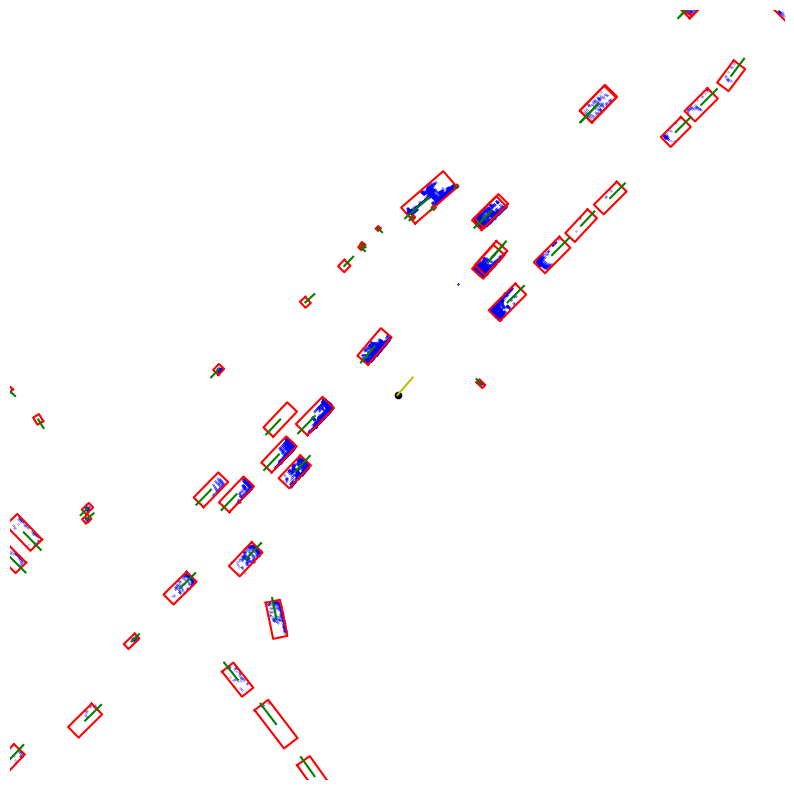

In [313]:
# Function to load a point cloud and view BEV
ignored_sem_classes = [4, 5, 6, 7, 8, 9, 10, 11, 12, 35, 36, 38, 41, 42]
def load_filtered_pointclouds(scene):
    scene_data = pandaset[scene].load_lidar().load_timestamps().load_semseg()
    scene_lidars = scene_data.lidar.data
    scene_poses = scene_data.lidar.poses
    for i in range(len(scene_lidars)):
        points = scene_lidars[i].to_numpy()[:,:3]
        # Filter out classes ground, buildings,etc
        semseg = scene_data.semseg.data[i]
        semseg["ignored"] = False
        for ignored_class in ignored_sem_classes:
            semseg.loc[semseg["class"] == ignored_class, "ignored"] = True
        scene_lidars[i] = {
            'points': points[~semseg["ignored"].values],
            'pose': scene_poses[i]
        }
    return scene_lidars

def normalize_angle(angle):
    # Normalize angle to be within the range [-pi, pi]
    normalized_angle = (angle + np.pi) % (2 * np.pi) - np.pi
    return normalized_angle

def get_box(box):
    x,y = box[0], box[1]
    l,w = box[3], box[4]
    yaw = normalize_angle(box[6] + np.pi/2)
    corners = np.array([
        [x + w/2, y + l/2],  # Top-right
        [x - w/2, y + l/2],  # Top-left
        [x - w/2, y - l/2],  # Bottom-left
        [x + w/2, y - l/2]   # Bottom-right
    ])
    R = np.array([
        [np.cos(yaw), -np.sin(yaw)],
        [np.sin(yaw), np.cos(yaw)]
    ])
    centered_corners = corners - np.array([x, y])
    rotated_corners = R @ centered_corners.T
    corners = rotated_corners.T + np.array([x, y])
    return corners

def view_point_cloud_bev_from_scene(scene_lidar, scene_cuboids, frame, obj_of_interest=None):
    points = scene_lidar[frame]['points']
    pose = scene_lidar[frame]['pose']
    
    # Create a scatter plot
    plt.figure(figsize=(10, 10))  # Set the figure size as needed
    plt.scatter(points[:,0], points[:,1], c='blue', marker='o', s=0.05)  # You can change the color and marker style

    # ego
    ego_x, ego_y = pose['position']['x'], pose['position']['y']
    plt.scatter(ego_x, ego_y, c='black', marker='o', s=20)
    quat = R.from_quat([pose['heading']['x'], pose['heading']['y'], pose['heading']['z'], pose['heading']['w']])
    yaw = normalize_angle(quat.as_euler('zyx', degrees=False)[0] + np.pi/2)
    end_x = ego_x + 3 * np.cos(yaw)  # Cosine for the horizontal component
    end_y = ego_y + 3 * np.sin(yaw)  # Sine for the vertical component
    plt.plot([ego_x,end_x], [ego_y,end_y], 'y-')

    # cuboids
    np_boxes = []
    cuboids = scene_cuboids[frame]
    for b in cuboids:
        np_boxes.append([b['position'][0], b['position'][1], b['position'][2],
                         b['dim'][0], b['dim'][1], b['dim'][2],
                         b['yaw']])
    np_boxes = np.asarray(np_boxes)
    for i in range(np_boxes.shape[0]):
        corners = get_box(np_boxes[i])
        corners = np.vstack([corners, corners[0]])
        plt.plot(corners[:, 0], corners[:, 1], 'r')

    # Add heading
    headings = []
    length = 1.5
    for box in np_boxes:
        x,y = box[0], box[1]
        yaw = normalize_angle(box[6] + np.pi/2)
        end_x = x + length * box[3] * np.cos(yaw)  # Cosine for the horizontal component
        end_y = y + length * box[3] * np.sin(yaw)  # Sine for the vertical component
        headings.append(np.array([[x, end_x], [y, end_y]]))
    headings = np.array(headings)
    for i in range(headings.shape[0]):
        plt.plot(headings[i][0], headings[i][1], 'g-')

    if obj_of_interest is not None:
        plt.scatter(obj_of_interest[:,0], obj_of_interest[:,1], c='brown', marker='o', s=0.05)

    # Setting the aspect of the plot to be equal, to maintain the scale of x and y    
    plt.axis('equal')
    plt.axis('off')
    plt.xlim(ego_x-50, ego_x+50)
    plt.ylim(ego_y-50, ego_y+50)
    plt.show()

scene = '001'
view_point_cloud_bev_from_scene(load_filtered_pointclouds(scene), cuboids[scene], 60)

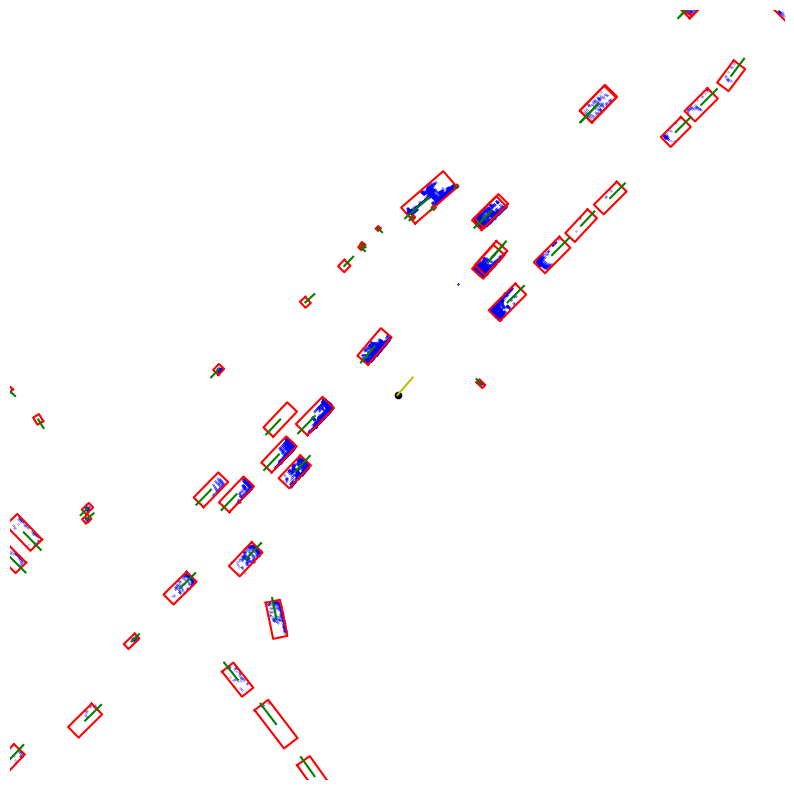

  5%|█▎                        | 4/76 [00:26<07:48,  6.50s/it]


KeyboardInterrupt: 

In [298]:
lidars = {}
for scene in tqdm(scenes):
    lidars[scene] = load_filtered_pointclouds(scene)

with open('/work_dir/diffusion-point-cloud/experiment/lidars.pkl', 'wb') as file:
    pkl.dump({'lidars': lidars}, file)

In [314]:
with open('/work_dir/diffusion-point-cloud/experiment/lidars.pkl', 'rb') as file:
    scene_lidars = pkl.load(file)['lidars']

In [443]:
# Function to get masks for points within a box
def points_in_rotated_box(corners, points):
    
    corners = np.array(corners)
    points = np.array(points)
    
    num_corners = len(corners)
    inside = np.ones(points.shape[0], dtype=bool)
    
    for i in range(num_corners):
        start = corners[i]
        end = corners[(i + 1) % num_corners]
        
        edge_vector = np.array(end) - np.array(start)
        point_vectors = points - start
        
        cross_products = edge_vector[0] * point_vectors[:, 1] - edge_vector[1] * point_vectors[:, 0]
        
        # Determine the sign of the cross product that indicates "inside"
        if i == 0:
            # Initial comparison side (either positive or negative)
            desired_sign = np.sign(cross_products)
            # Handling the case where the cross product is zero (points are exactly on the edge)
            desired_sign = np.where(desired_sign == 0, 1, desired_sign)  # Choose inside if on line
        else:
            current_signs = np.sign(cross_products)
            current_signs = np.where(current_signs == 0, desired_sign, current_signs)  # Maintain sign if on line
            inside &= (desired_sign == current_signs)
    
    return inside

In [476]:
from concurrent.futures import ThreadPoolExecutor, as_completed

classes_to_keep = ['pedestrian', 'bicycle', 'motorcycle', 'pickup truck', 'car']

def process_instance(cls, inst_id, scene_lidars, instances):
    instance = copy.copy(instances[cls][inst_id])
    box = instance['box']
    scene = instance['scene']
    frame = instance['frame']
    points = scene_lidars[scene][frame]['points']
    
    ego_pose = scene_lidars[scene][frame]['pose']
    ego_pos = [ego_pose['position']['x'], ego_pose['position']['y'], ego_pose['position']['z']]
    quat = R.from_quat([ego_pose['heading']['x'], ego_pose['heading']['y'],
                        ego_pose['heading']['z'], ego_pose['heading']['w']])
    ego_yaw = normalize_angle(quat.as_euler('zyx', degrees=False)[0] + np.pi/2)

    inst_pos = box['position']
    inst_shape = box['dim']
    inst_yaw = normalize_angle(box['yaw'] + np.pi/2)

    # Compute view from ego to instance
    vec = np.array(inst_pos[:2]) - np.array(ego_pos[:2])
    instance['box']['view_angle'] = np.arctan2(vec[1], vec[0])
    instance['box']['dist_to_ego'] = np.linalg.norm(vec)
    instance['box']['yaw'] = inst_yaw

    # Extract the points
    margin = 1.1
    box_np = ([box['position'][0], box['position'][1], box['position'][2],
               box['dim'][0] * margin, box['dim'][1] * margin, box['dim'][2] + margin,
               box['yaw']])
    corners = get_box(box_np)
    corners = np.vstack([corners, corners[0]])
    object_points_mask = points_in_rotated_box(corners, points[:,:2])
    object_points = points[object_points_mask]
    instance['points'] = object_points
    instance['num_points'] = object_points.shape[0]
    if object_points.shape[0] > 0:
        return instance
    return None

def extract_with_threads(scene_lidars, classes_to_keep, instances, min_num_points=2048, num_thread=4):
    total_tasks = sum(len(instances[cls]) for cls in classes_to_keep)
    new_instances = {cls: [] for cls in classes_to_keep}
    with ThreadPoolExecutor(max_workers=len(classes_to_keep)) as executor:
        future_to_class = {}
        for cls in classes_to_keep:
            for inst_id in tqdm(range(len(instances[cls]))):
                future = executor.submit(process_instance, cls, inst_id, scene_lidars, instances)
                future_to_class[future] = cls
        
        # Progress tracking with tqdm
        with tqdm(total=total_tasks, desc="Processing Instances") as progress:
            for future in as_completed(future_to_class):
                cls = future_to_class[future]
                result = future.result()
                if result:
                    new_instances[cls].append(result)
                progress.update(1)  # Update progress after each task completion

    return new_instances

# Usage example:
objects = extract_with_threads(scene_lidars, classes_to_keep, instances, num_thread=6)

with open('/work_dir/diffusion-point-cloud/experiment/objects.pkl', 'wb') as file:
    pkl.dump({'objects': objects}, file)

100%|██████████████| 719047/719047 [00:21<00:00, 33122.23it/s]
Processing Instances: 100%|█| 854710/854710 [22:59<00:00, 619.


In [545]:
with open('/work_dir/diffusion-point-cloud/experiment/objects.pkl', 'rb') as file:
    objects = pkl.load(file)['objects']

num_objects = [{cls: len(objects[cls])} for cls in objects.keys()]
print('Before')
print(num_objects)
min_num_points_per_class = {
    'car': 2048,
    'pedestrian': 256,
    'pickup truck': 1024,
    'bicycle': 256,
    'motorcycle': 256
}

# filter out by number of points
filtered = {}
for cls in objects.keys():
    filtered[cls] = []
    for obj in tqdm(objects[cls]):
        if obj['num_points'] > min_num_points_per_class[cls]:
            indices = np.random.choice(obj['num_points'], min_num_points_per_class[cls], replace=False)
            obj['points'] = obj['points'][indices, :]
            filtered[cls].append(obj)
objects = filtered
num_objects = [{cls: len(objects[cls])} for cls in objects.keys()]
print('After')
print(num_objects)

Before
[{'pedestrian': 74596}, {'bicycle': 7417}, {'motorcycle': 5002}, {'pickup truck': 22968}, {'car': 414050}]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 414050/414050 [00:01<00:00, 213913.73it/s]

After
[{'pedestrian': 2887}, {'bicycle': 472}, {'motorcycle': 162}, {'pickup truck': 1568}, {'car': 10092}]


Num Points 2690


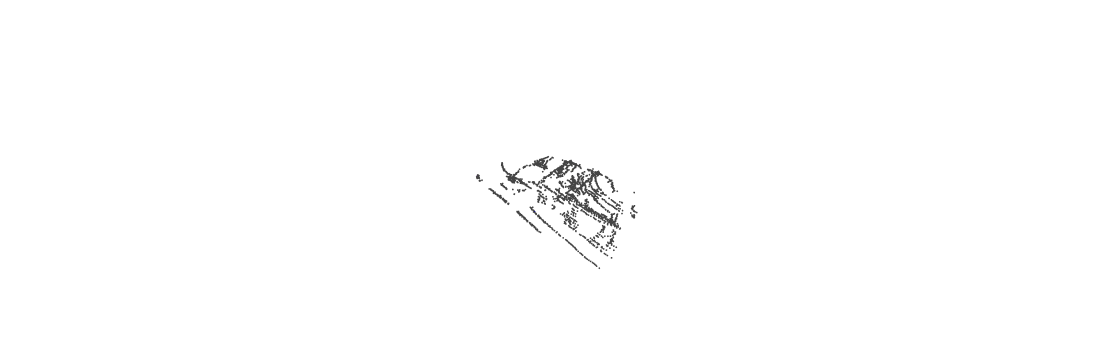

In [551]:
import plotly.graph_objects as go
def view_object(object_points, colors=(238, 75, 43)):
    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=object_points[:,0], y=object_points[:,1], z=object_points[:,2], 
                mode='markers',
                marker=dict(size=1, color=colors)
            )
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        )
    )
    fig.show()

i = 1000
cls = 'car'
print('Num Points', objects[cls][i]['num_points'])
view_object(objects[cls][i]['points'])

# Further...
Plot the mapping from average distance to ego vs average number of points (for each class)

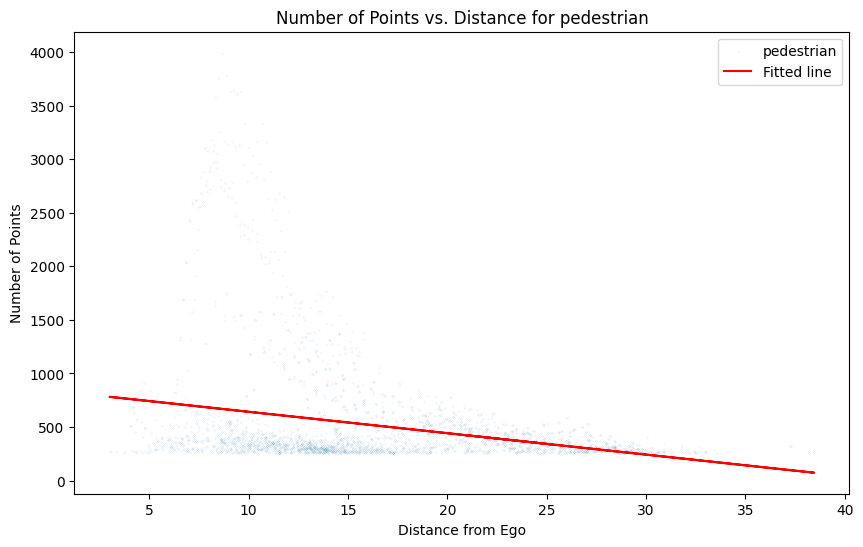

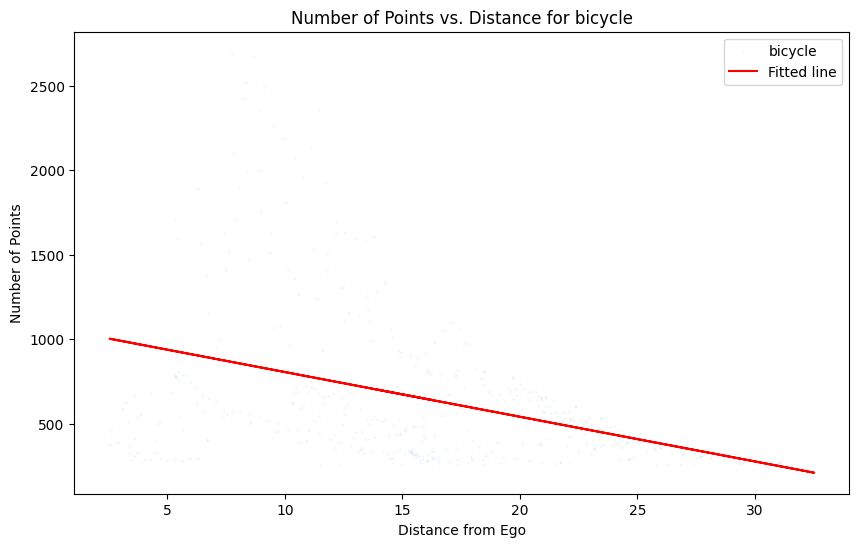

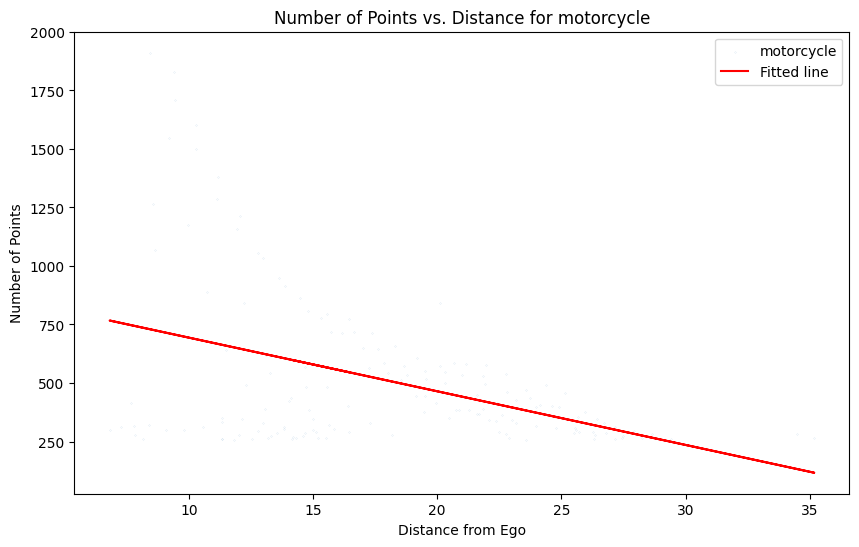

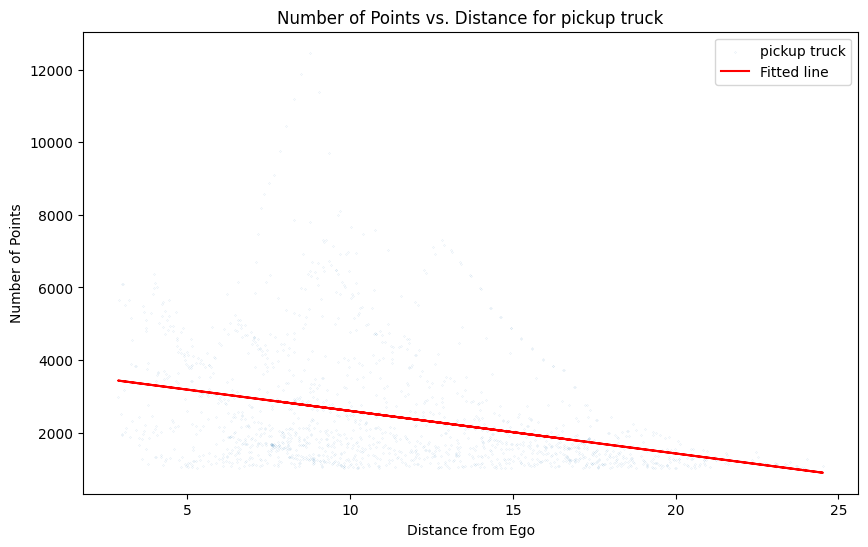

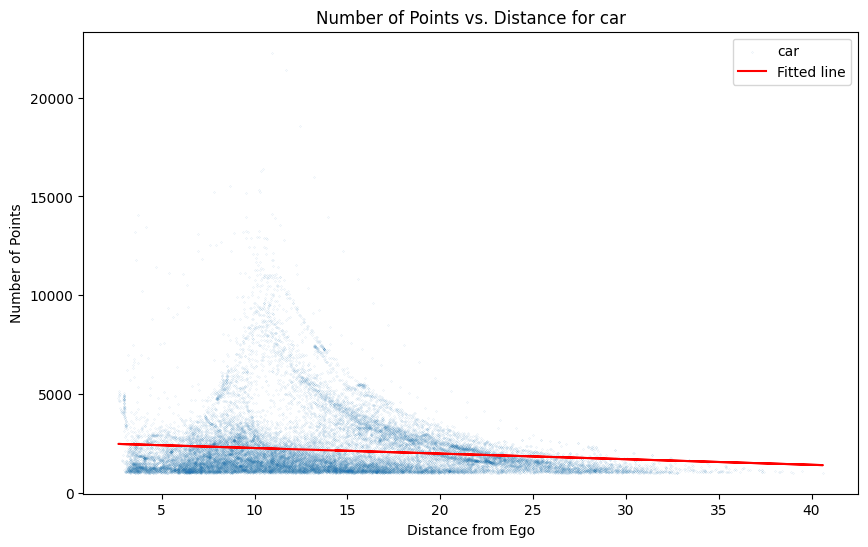

In [512]:
from scipy import stats

def plot_distance_num_point(objects, classes_to_keep):
    for cls in classes_to_keep:
        cls_objects = objects[cls]
        num_points = np.array([box['num_points'] for box in cls_objects])
        dist_from_ego = np.array([box['box']['dist_to_ego'] for box in cls_objects])

        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(dist_from_ego, num_points)
        
        # Create a line of best fit
        line = slope * dist_from_ego + intercept

        # Plotting the scatter plot
        plt.figure(figsize=(10, 6))
        plt.scatter(dist_from_ego, num_points, alpha=0.7, s=0.005, label=cls)
        plt.plot(dist_from_ego, line, 'r', label='Fitted line')
        
        # Add titles and labels
        plt.title(f'Number of Points vs. Distance for {cls}')
        plt.xlabel('Distance from Ego')
        plt.ylabel('Number of Points')
        
        # Show legend
        plt.legend()
        
        # Display the plot
        plt.show()

plot_distance_num_point(objects, classes_to_keep)

# Create Dataset...
Uniformly sample based on view angle for each class

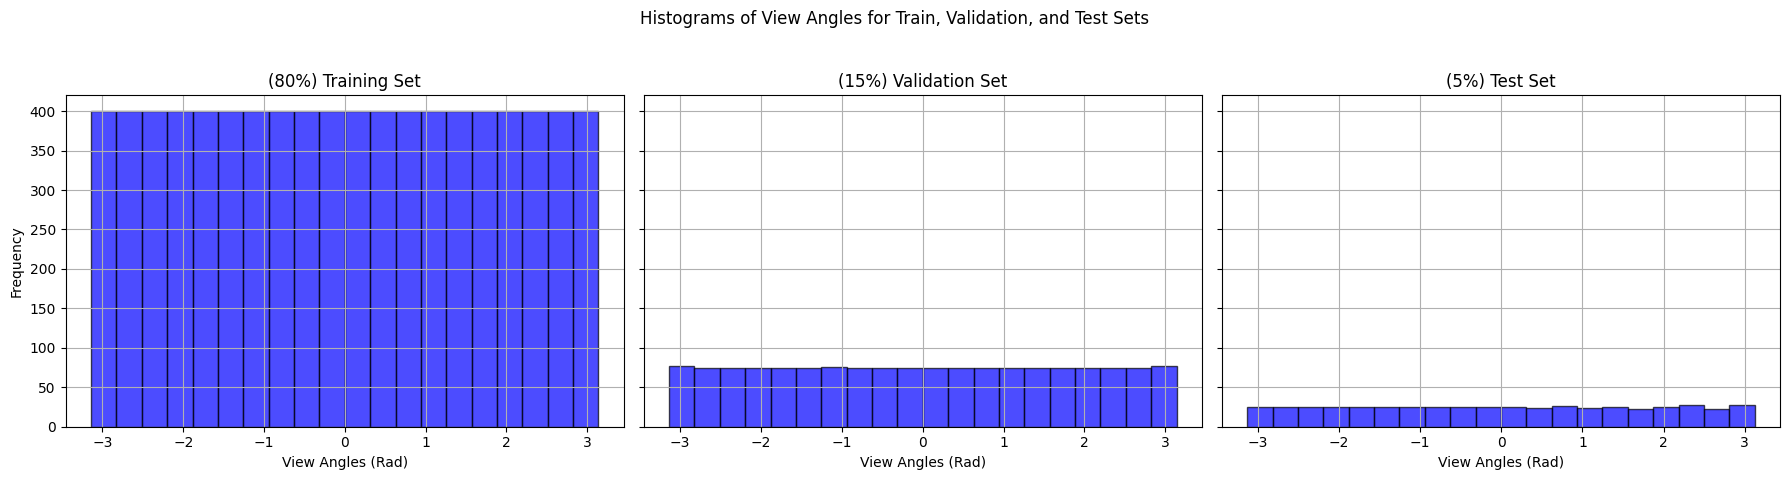

In [541]:
from sklearn.model_selection import train_test_split

# Reconstruct the sampled data into the original list of dictionaries format
def reconstruct_dict(row):
    # This should match the original structure of your dictionaries
    return {
        'box': {
            'position': row['box_position'],
            'dim': row['box_dim'],
            'yaw': row['box_yaw'],
            'cls': row['box_cls'],
            'uuid': row['box_uuid'],
            'view_angle': row['box_view_angle'],
            'dist_to_ego': row['box_dist_to_ego']
        },
        'frame': row['frame'],
        'scene': row['scene'],
        'points': np.array(row['points'], dtype=np.float64).reshape(-1, 3)  # Adjust the reshape params as needed
    }

def uniformly_sample_and_split_by_bins(objects, cls, num_bins=20, max_samples=10000, train_size=0.8, val_size=0.15, test_size=0.05):
    # Sample N amount of pointclouds for the dataset, based on uniform sampling using view angle
    sorted_list = sorted(objects[cls], key=lambda x: x['box']['view_angle'])

    total_samples = min(max_samples, len(sorted_list))
    
    df = pd.json_normalize(sorted_list, sep='_')
    
    # Create bins based on the range of view angles
    min_angle = df['box_view_angle'].min()
    max_angle = df['box_view_angle'].max()
    bins = np.linspace(min_angle, max_angle, num_bins+1)
    
    # Assign each data point to a bin
    df['bin'] = pd.cut(df['box_view_angle'], bins=bins, include_lowest=True, labels=False)
    
    # Calculate how many samples per bin for each set
    samples_per_bin = total_samples // num_bins
    train_per_bin = int(train_size * samples_per_bin)
    val_per_bin = int(val_size * samples_per_bin)
    # The test_per_bin could be calculated similarly, but to ensure the total adds up to samples_per_bin,
    # we take the remainder of the division for the test set.
    test_per_bin = samples_per_bin - train_per_bin - val_per_bin

    # Initialize lists to hold the sampled data for each set
    train_data, validation_data, test_data = [], [], []

    # Sample uniformly from each bin and split
    for b in range(num_bins):
        bin_df = df[df['bin'] == b]
        bin_sample = bin_df.sample(n=samples_per_bin, replace=False) if len(bin_df) >= samples_per_bin else bin_df.sample(n=samples_per_bin, replace=True)

        # Split the samples of this bin into train, validation, and test
        bin_train, bin_remain = train_test_split(bin_sample, train_size=train_per_bin, random_state=42)
        bin_val, bin_test = train_test_split(bin_remain, test_size=test_per_bin / (val_per_bin + test_per_bin), random_state=42)

        # Extend the main data lists
        train_data.extend(bin_train.to_dict('records'))
        validation_data.extend(bin_val.to_dict('records'))
        test_data.extend(bin_test.to_dict('records'))

    # Use list comprehension to apply the reconstruction to each sampled row
    train_data = [reconstruct_dict(row) for row in train_data]
    validation_data = [reconstruct_dict(row) for row in validation_data]
    test_data = [reconstruct_dict(row) for row in test_data]

    return train_data, validation_data, test_data

train_data, validation_data, test_data = uniformly_sample_and_split_by_bins(objects, 'car', num_bins=20)
car_dataset = {
    'train': train_data,
    'val': validation_data,
    'test': test_data
}

def plot_sub_histograms(train_data, validation_data, test_data, num_bins):
    data_sets = {
        '(80%) Training': train_data,
        '(15%) Validation': validation_data,
        '(5%) Test': test_data
    }
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    fig.suptitle('Histograms of View Angles for Train, Validation, and Test Sets')

    for ax, (set_name, data) in zip(axes, data_sets.items()):
        view_angles = [box['box']['view_angle'] for box in data]
        ax.hist(view_angles, bins=num_bins, alpha=0.7, color='blue', edgecolor='black')
        ax.set_title(f'{set_name} Set')
        ax.set_xlabel('View Angles (Rad)')
        ax.grid(True)

    axes[0].set_ylabel('Frequency')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
plot_sub_histograms(train_data, validation_data, test_data, num_bins)

car


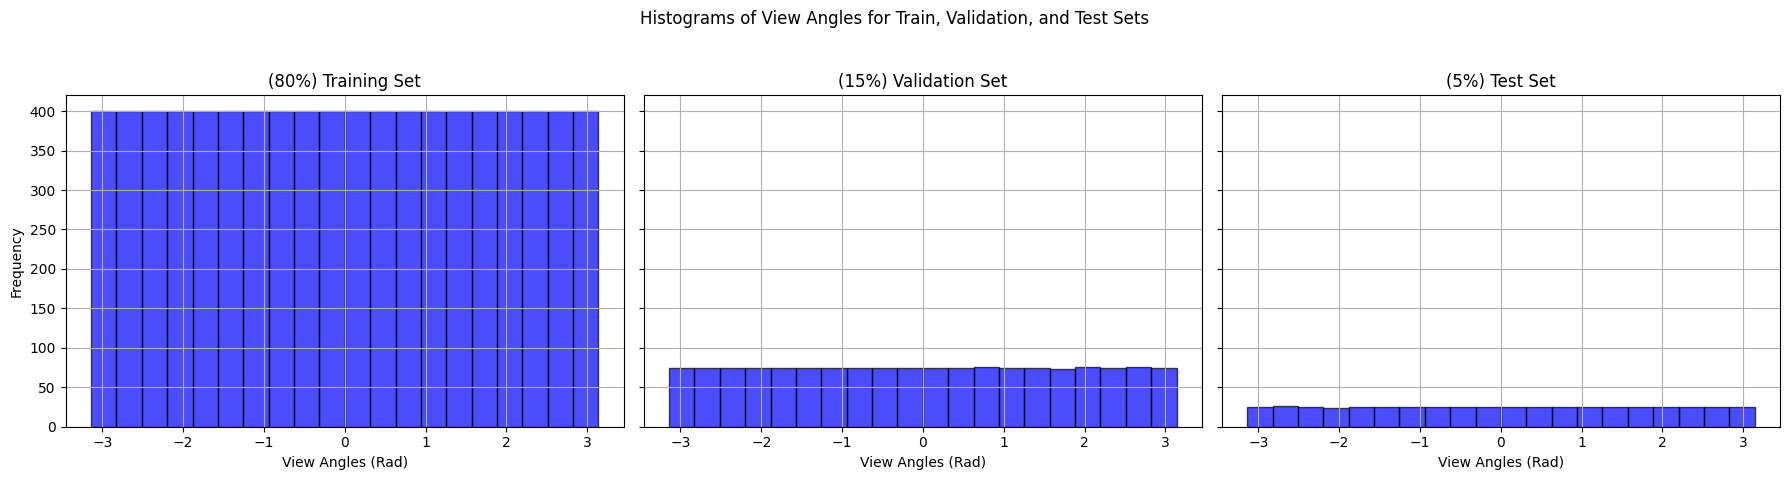

pedestrian


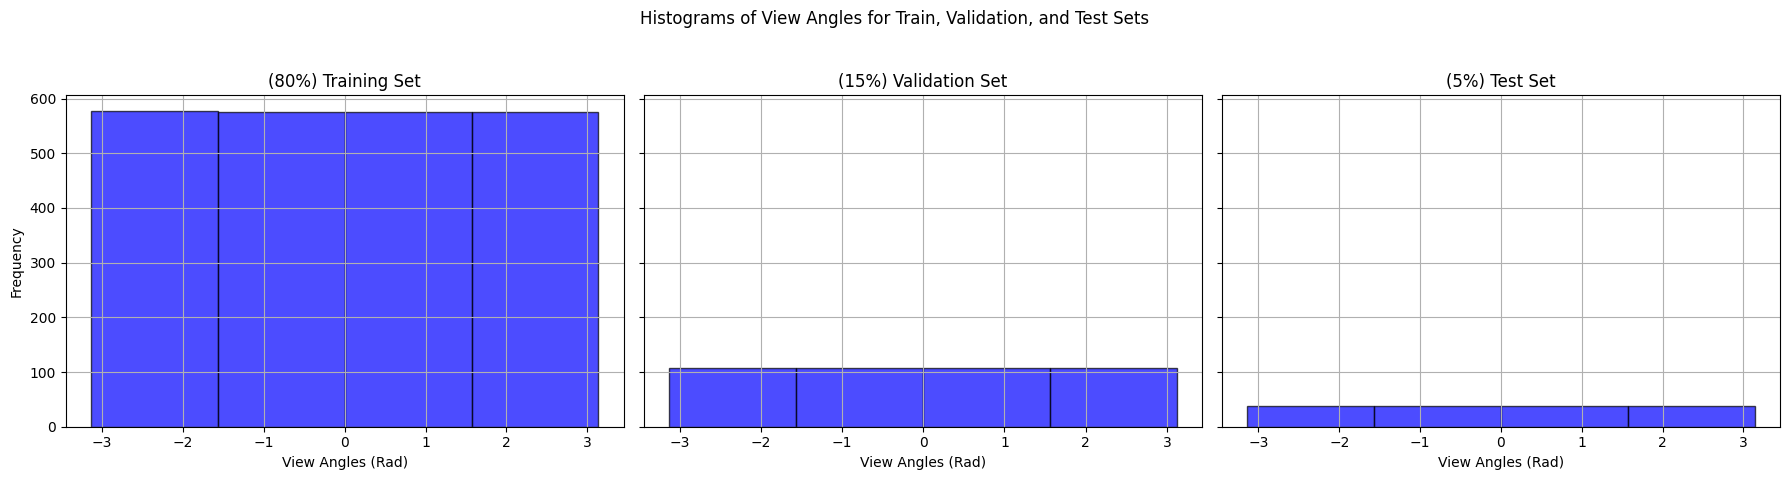

pickup truck


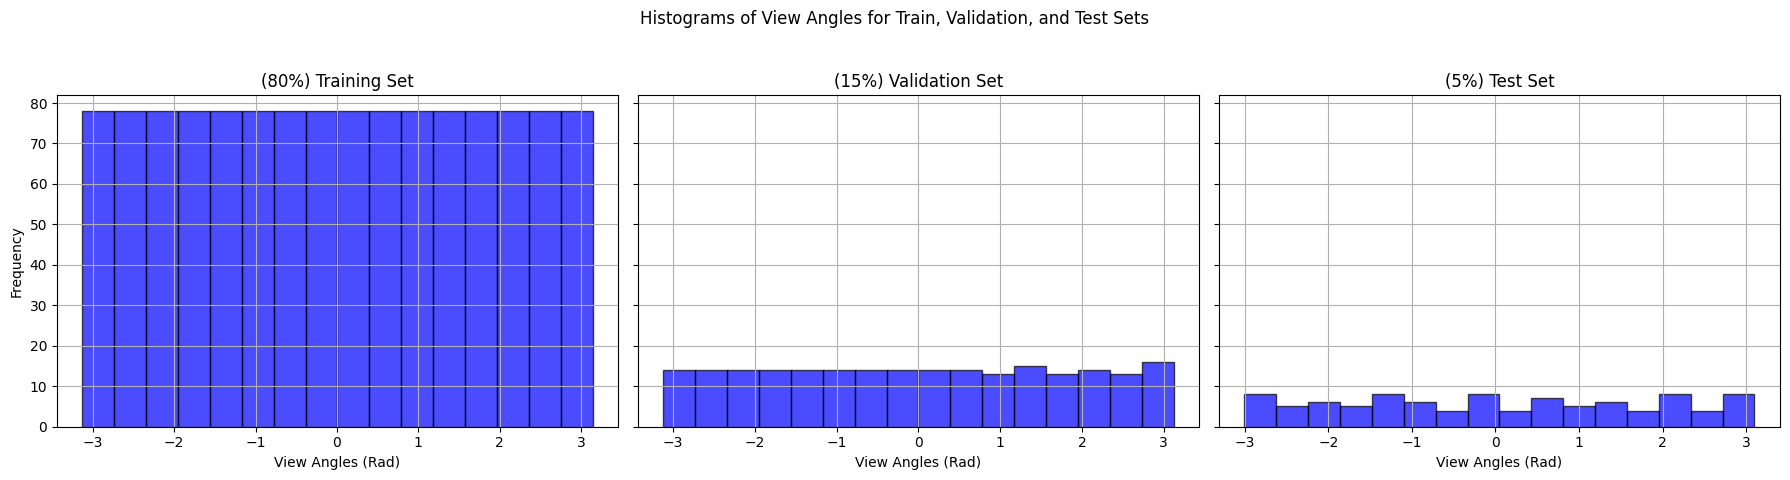

bicycle


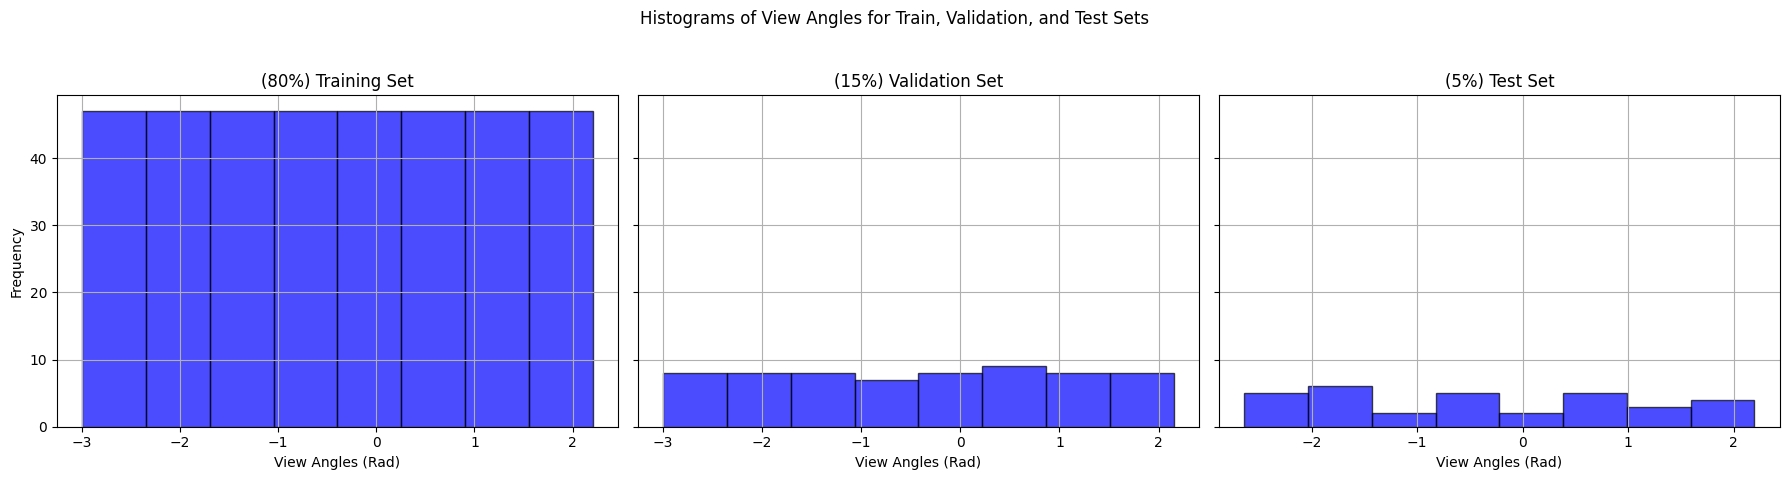

In [547]:
# Create data
dataset = {}
num_bins_per_class = {
    'car': 20,
    'pedestrian': 4,
    'pickup truck': 16,
    'bicycle': 8
}
for cls in num_bins_per_class.keys():
    print(cls)
    train_data, validation_data, test_data = uniformly_sample_and_split_by_bins(objects, cls, num_bins=num_bins_per_class[cls])
    plot_sub_histograms(train_data, validation_data, test_data, num_bins_per_class[cls])
    dataset[cls] = {
        'train': train_data,
        'val': validation_data,
        'test': test_data
    }

In [548]:
with open('/work_dir/diffusion-point-cloud/data/pandaset.pkl', 'wb') as file:
    pkl.dump(dataset, file)

In [508]:
dataset['car']

{'train': [{'box': {'position': [-12.879, -22.938, 0.094],
    'dim': [1.884, 4.775, 1.593],
    'yaw': 1.0792243429622808,
    'cls': 'car',
    'uuid': '556dbb17-190f-4e2b-b00a-d66f779ab018',
    'view_angle': -2.984923800263746,
    'dist_to_ego': 19.10013388840014},
   'frame': 17,
   'scene': '052',
   'points': array([[-1.30793138e+01, -2.49454397e+01, -7.54046399e-02],
          [-1.30635978e+01, -2.48718620e+01, -7.24033289e-02],
          [-1.31321115e+01, -2.48850444e+01, -4.27794211e-01],
          ...,
          [-1.20112717e+01, -2.07715340e+01, -2.95557426e-01],
          [-1.22988580e+01, -2.07136455e+01,  3.82673569e-03],
          [-1.23263777e+01, -2.07117740e+01, -3.25324051e-01]])},
  {'box': {'position': [-2.869, -4.21, 0.466],
    'dim': [1.719, 4.315, 1.775],
    'yaw': -2.074327403012081,
    'cls': 'car',
    'uuid': '60c572c5-321d-478e-a236-b2c8461e318a',
    'view_angle': -2.9174460104120565,
    'dist_to_ego': 7.705453402123559},
   'frame': 3,
   'scene': '